<a href="https://colab.research.google.com/github/Redcoder815/Deep_Learning_PyTorch/blob/main/24RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

The torch.randn(T) function generates a tensor containing T random numbers. These random numbers are drawn from a standard normal distribution (also known as a Gaussian distribution), meaning they have a mean of 0 and a variance of 1.

--------------

Let's use a simpler, conceptual example. Imagine you have the following three individual feature sequences, which are 1D tensors, generated by the [self.x[i : self.T-self.tau+i] for i in range(self.tau)] part:

Feature Sequence 0 (lag 0): [10, 11, 12, 13]
Feature Sequence 1 (lag 1): [11, 12, 13, 14]
Feature Sequence 2 (lag 2): [12, 13, 14, 15]
These are your features list. When you apply torch.stack(features, 1):

dim=1 means that the new dimension is added in the second position (index 1). Think of it like taking the first element from each sequence, then the second element from each sequence, and so on, to form new 'rows' or 'time steps' for your combined feature set.

The resulting self.features tensor would look like this:

[[10, 11, 12],  // First element from sequence 0, then 1, then 2
 [11, 12, 13],  // Second element from sequence 0, then 1, then 2
 [12, 13, 14],  // Third element from sequence 0, then 1, then 2
 [13, 14, 15]]   // Fourth element from sequence 0, then 1, then 2
Interpretation:

The shape of this new tensor is (4, 3).
Each row represents a specific time step in your dataset. For example, the first row [10, 11, 12] would be the features used to predict the target at a particular time.
Each column within a row represents a different lagged version of the original data. So, 10 is the x value at the current 'time', 11 is x at time + 1 (or time - 1 depending on how you define your lags), and 12 is x at time + 2 (or time - 2).
This structure is commonly used to create input sequences for recurrent neural networks (RNNs) or other sequence models, where each row is an input vector for a specific point in time, and the columns are its historical context (lags).

-------------

Imagine your original x data is: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19] And your tau (the number of lags for your features) is 3.

self.x[self.tau:]: This part slices the self.x tensor. It means "start from index self.tau and go to the end of the tensor." Since self.tau is 3, we start at index 3.

Original x: [10, 11, 12, **13**, 14, 15, 16, 17, 18, 19] Index: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9

So, self.x[3:] would give you: [13, 14, 15, 16, 17, 18, 19]

This effectively means that if your features for a given time step are [10, 11, 12] (lags 0, 1, 2), the label corresponding to those features is 13 (the value after the lagged features).

.reshape((-1, 1)): After slicing, you have a 1D tensor (e.g., [13, 14, 15, 16, 17, 18, 19]). The .reshape((-1, 1)) method changes its shape.

(-1): This tells PyTorch to automatically calculate the size of this dimension based on the total number of elements and the other specified dimensions. In this case, it will be the number of elements in your sliced tensor (which is 7).
(1): This specifies that the second dimension should have a size of 1. This effectively turns your 1D tensor into a 2D column vector.
So, [13, 14, 15, 16, 17, 18, 19].reshape((-1, 1)) becomes:

[[13],
 [14],
 [15],
 [16],
 [17],
 [18],
 [19]]
Why is this done?

Most machine learning models, especially for supervised learning, expect the target variable (labels) to be in a specific shape, often a 2D array where each row corresponds to a sample and each column to a target feature (even if there's only one target feature). Reshaping it to (-1, 1) creates a column vector, which is a standard format for single-output predictions in many neural network frameworks.

--------------
Let's break down the line i = slice(0, self.num_train) if train else slice(self.num_train, None) with a conceptual example.

This is a conditional expression that's used to create a slice object, which is then used to select specific parts of your dataset for either training or validation/testing.

Imagine you have a full dataset of 1000 items (e.g., self.features or self.labels), and you've decided that self.num_train (the number of training examples) is 800. So, self.num_train = 800.

Now, let's look at the two possible scenarios:

If train is True (meaning you want the training data): The expression becomes i = slice(0, self.num_train).

This creates a slice object that effectively means "start from index 0 and go up to (but not including) index 800."
So, i would represent the range [0, 1, ..., 799]. When you apply this i to your dataset (e.g., self.features[i]), it would select the first 800 rows/samples for training.
If train is False (meaning you want the validation/test data): The expression becomes i = slice(self.num_train, None).

This creates a slice object that means "start from index self.num_train (800) and go to the None (which means the end) of the dataset."
So, i would represent the range [800, 801, ..., 999] (assuming a total of 1000 items). When you apply this i to your dataset, it would select the remaining items (from index 800 to the end) for validation or testing.
In summary, this single line elegantly handles the logic of creating the correct slice to split your data into training and non-training sets based on the train boolean flag.

----------------

self.get_tensorloader([self.features, self.labels], train, i) conceptually.

This line is calling a method named get_tensorloader within your Data class. Its primary purpose is to take your processed features and labels, apply the training/validation split, and then typically wrap them in a data loader object (like PyTorch's DataLoader). This data loader is essential for efficiently feeding data in batches to your neural network during training or evaluation.

Here's what each part means:

[self.features, self.labels]: This is a list containing two tensors:

self.features: This is the tensor you created with torch.stack, where each row represents a set of lagged input features for a particular time step. For example:
[[10, 11, 12],
 [11, 12, 13],
 [12, 13, 14],
 [13, 14, 15]]
self.labels: This is the tensor you created by slicing and reshaping self.x, where each row is the target value corresponding to the self.features row at the same index. For example (assuming tau=3 and self.features above, labels would be the next value after the features):
[[13],
 [14],
 [15],
 [16]]
train: This is a boolean flag (True or False) that indicates whether you want the training dataset or the validation/test dataset.

i: This is the slice object we just discussed (e.g., slice(0, self.num_train) for training or slice(self.num_train, None) for validation/test).

How it works with an example:

Imagine you have self.features and self.labels as shown above, each with 4 rows. Let's say self.num_train is 3.

If train is True: The value of i would be slice(0, 3). The get_tensorloader method would then use this slice to select the first 3 rows from both self.features and self.labels:

Selected Features: [[10, 11, 12], [11, 12, 13], [12, 13, 14]]
Selected Labels: [[13], [14], [15]] It would then create a data loader specifically for training, allowing your model to iterate over these batches.
If train is False: The value of i would be slice(3, None). The get_tensorloader method would use this slice to select the remaining rows (from index 3 to the end) from both self.features and self.labels:

Selected Features: [[13, 14, 15]]
Selected Labels: [[16]] It would then create a data loader for validation or testing, using these remaining samples.
In essence, self.get_tensorloader acts as a data pipeline component, taking your prepared data, splitting it appropriately, and packaging it into an iterable format ready for model consumption.

In [2]:
class Data():
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2
        self.T = T # Added T to instance attributes
        self.tau = tau # Added tau to instance attributes
        self.num_train = num_train # Added num_train to instance attributes
        self.batch_size = batch_size # Added batch_size to instance attributes

    def get_tensorloader(self, data_arrays, train, i):
        # Use the slice i to extract the relevant features and labels
        features = data_arrays[0][i]
        labels = data_arrays[1][i]
        # Create a TensorDataset
        dataset = TensorDataset(features, labels)
        # Instantiate a DataLoader
        dataloader = DataLoader(dataset, self.batch_size, shuffle=train)
        return dataloader

    def get_dataloader(self, train):
        features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
        self.features = torch.stack(features, 1)
        self.labels = self.x[self.tau:].reshape((-1, 1))
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.features, self.labels], train, i)

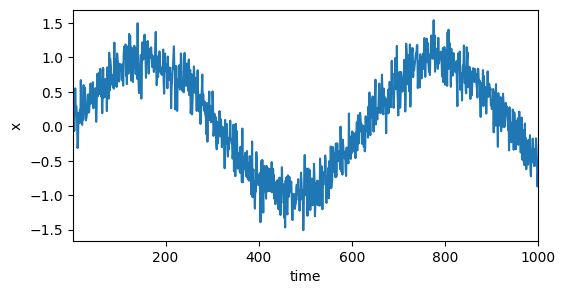

In [3]:
data = Data()
plt.figure(figsize=(6, 3))
plt.plot(data.time, data.x)
plt.xlabel('time')
plt.ylabel('x')
plt.xlim(1, 1000)
plt.show()

In [4]:
import collections
import random
import re
import torch

Let's break down re.sub('[^A-Za-z]+', ' ', text) conceptually, focusing on the regular expression part.

re.sub(pattern, replacement, string) is a function from Python's re (regular expression) module. Its job is to find all occurrences of a pattern within a string and replace them with the replacement.

Now, let's look at each piece:

'[^A-Za-z]+' (the pattern):

[ and ]: These define a character set. Any character inside these brackets will be matched.
^: When ^ is the first character inside a character set ([ and ]), it negates the set. So, [^...] means "match any character not in this set."
A-Za-z: This specifies all uppercase letters from A to Z and all lowercase letters from a to z.
Putting [^A-Za-z] together means: "Match any character that is not an English alphabet letter (neither uppercase nor lowercase)."
+: This is a quantifier that means "one or more" of the preceding element. So, [^A-Za-z]+ means "match one or more consecutive characters that are not English alphabet letters."
In summary, the pattern [^A-Za-z]+ will find any sequence of non-alphabetic characters (like numbers, punctuation, spaces, newlines, etc.).

' ' (the replacement): This is a single space character. Every time the pattern is found, it will be replaced by this single space.

text (the string): This is the input string where the search and replace operation will take place.

Conceptual Example:

Let's say your text is: "The Time Machine, by H. G. Wells [1898]\n\n\nI\n\nThe Time Traveller"

Here's how re.sub('[^A-Za-z]+', ' ', text) would process it:

Original: "The Time Machine, by H. G. Wells [1898]\n\n\nI\n\nThe Time Traveller"
The first non-alphabetic sequence is ', ' after "Machine". This will be replaced by a single space.
Then ', ' after "Wells". Replaced by a single space.
Then '[ after "G.". Replaced by a single space.
Then '1898] after "Wells". Replaced by a single space.
Then \n\n\n and \n\n (newlines and spaces). All these consecutive non-alphabetic characters will be replaced by a single space.
The result would conceptually be something like: "The Time Machine by H G Wells I The Time Traveller"

It effectively cleans the text by removing all punctuation, numbers, and multiple spaces/newlines, replacing them all with a single space to separate words.

------------

Certainly! Let's explain corpus = [vocab[token] for token in tokens] with a conceptual example.

This line is a list comprehension that converts a list of tokens (individual characters or words) into a corpus of numerical indices. This numerical representation is what machine learning models typically understand.

Let's assume the following:

Your tokens list contains individual characters from a processed text, for example: tokens = ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e']
Your vocab object (an instance of the Vocab class) has an internal mapping from characters to their numerical indices. Let's say it maps:
't' to 21
'h' to 9
'e' to 6
' ' (space) to 0
'i' to 10
'm' to 14
Now, let's break down the list comprehension step by step:

for token in tokens: This part sets up a loop that iterates over each element in your tokens list.

First iteration: token is 't'
Second iteration: token is 'h'
Third iteration: token is 'e'
Fourth iteration: token is ' '
Fifth iteration: token is 't'
Sixth iteration: token is 'i'
Seventh iteration: token is 'm'
Eighth iteration: token is 'e'
vocab[token]: For each token in the loop, this calls the __getitem__ method of your vocab object with that single token. The vocab.__getitem__(token) method looks up the numerical index for the token in its internal token_to_idx dictionary. If the token is not found, it returns the index for the <unk> (unknown) token.

When token is 't', vocab['t'] returns 21.
When token is 'h', vocab['h'] returns 9.
When token is 'e', vocab['e'] returns 6.
When token is ' ', vocab[' '] returns 0.
When token is 't', vocab['t'] returns 21.
When token is 'i', vocab['i'] returns 10.
When token is 'm', vocab['m'] returns 14.
When token is 'e', vocab['e'] returns 6.
[ ... ]: As each vocab[token] operation returns an index, these indices are collected into a new list.

Final Result: After iterating through all the tokens, the corpus list will contain the numerical representations:

corpus = [21, 9, 6, 0, 21, 10, 14, 6]

This corpus is now a sequence of integers, ready to be used as input for a neural network, for example.

--------------------
Resulting self.X:

[[10, 11, 12],
 [11, 12, 13],
 [12, 13, 14],
 [13, 14, 15]]
This self.X represents the input sequences for your model.

array[:,1:] (for self.Y)

: before the comma again means "take all rows".
1: after the comma means "take all columns starting from index 1 (the second column) to the end".
So, self.Y will contain the last 3 elements of each row from array.
Resulting self.Y:

[[11, 12, 13],
 [12, 13, 14],
 [13, 14, 15],
 [14, 15, 16]]
This self.Y represents the target sequences. Each element in self.Y is the token that immediately follows the corresponding token in self.X within the original sequence.



In [5]:
import requests

class TimeMachine():
    def __init__(self, batch_size = 2, num_steps = 10, num_train=10000, num_val=5000):
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.num_train = num_train
        self.num_val = num_val
        corpus, self.vocab = self.build(self._download())
        array = torch.tensor([corpus[i:i+num_steps+1]
                            for i in range(len(corpus)-num_steps)])
        self.X, self.Y = array[:,:-1], array[:,1:]

    def _download(self):
        url = 'http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt'
        response = requests.get(url)
        response.raise_for_status() # Raise an exception for HTTP errors
        return response.text

    def _preprocess(self, text):
        return re.sub('[^A-Za-z]+', ' ', text).lower()

    def _tokenize(self, text):
        return list(text)

    def build(self, raw_text, vocab=None):
        tokens = self._tokenize(self._preprocess(raw_text))
        if vocab is None: vocab = Vocab(tokens)
        corpus = [vocab[token] for token in tokens]
        return corpus, vocab

    def get_tensorloader(self, data_arrays, train, i):
        # This is a placeholder, actual implementation might vary based on inheritance.
        features = data_arrays[0][i]
        labels = data_arrays[1][i]
        dataset = TensorDataset(features, labels)
        dataloader = DataLoader(dataset, self.batch_size, shuffle=train)
        return dataloader

    def get_dataloader(self, train):
        idx = slice(0, self.num_train) if train else slice(
            self.num_train, self.num_train + self.num_val)
        return self.get_tensorloader([self.X, self.Y], train, idx)

isinstance(tokens[0], list) checks if the first element within the tokens list is itself a list.



-----------

Certainly! Let's break down tokens = [token for line in tokens for token in line] with a conceptual example. This is a common pattern in Python called a list comprehension, and it's used here to "flatten" a list of lists into a single, one-dimensional list.

Imagine you have a variable tokens that looks like this (it's a list where each element is another list, perhaps representing words or lines of text):

Original tokens (a list of lists):

[['h', 'e', 'l', 'l', 'o'], ['w', 'o', 'r', 'l', 'd']]
Here, the outer list contains two inner lists: ['h', 'e', 'l', 'l', 'o'] and ['w', 'o', 'r', 'l', 'd'].

Now, let's trace how the list comprehension works:

for line in tokens: This is the outer loop. It iterates through each inner list in the tokens variable.

First iteration: line becomes ['h', 'e', 'l', 'l', 'o']
Second iteration: line becomes ['w', 'o', 'r', 'l', 'd']
for token in line: This is the inner loop. For each line (which is an inner list), it then iterates through each individual character (token) within that line.

When line is ['h', 'e', 'l', 'l', 'o']:
token becomes 'h'
token becomes 'e'
token becomes 'l'
token becomes 'l'
token becomes 'o'
When line is ['w', 'o', 'r', 'l', 'd']:
token becomes 'w'
token becomes 'o'
token becomes 'r'
token becomes 'l'
token becomes 'd'
[token ...]: For every token that the inner loop processes, that token is added to the new list being constructed.

So, by the end of this process, all the individual characters from the inner lists are collected into a single, flat list. The tokens variable would then be reassigned to this new, flattened list:

Resulting tokens (a flattened list):

['h', 'e', 'l', 'l', 'o', 'w', 'o', 'r', 'l', 'd']
This technique is very efficient for transforming nested lists into a single list, which is often necessary when you need to process all elements uniformly, like when building a vocabulary from words or characters in a text.

------------------

Imagine your tokens list contains individual characters from a text, like this:

tokens = ['h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd', '!', '!', 'o']
When you execute counter = collections.Counter(tokens), it will go through this list and count how many times each unique item appears:

'h' appears once
'e' appears once
'l' appears twice
'o' appears twice
' ' (space) appears once
'w' appears once
'r' appears once
'd' appears once
'!' appears twice
The counter object would then conceptually look like this (though the exact order might vary, as dictionaries are unordered in older Python versions, but ordered by insertion in Python 3.7+):

Counter({'l': 2, 'o': 2, '!': 2, 'h': 1, 'e': 1, ' ': 1, 'w': 1, 'r': 1, 'd': 1})
Notice that the items that appear more frequently (like 'l', 'o', '!') might be listed first by default, as Counter often presents its most common elements first when iterating or converting to a list of items. In your Vocab class, this counter object is then used to sort the tokens by their frequency, which is a common step in building a vocabulary for natural language processing.

-------

counter.items(): This method converts the counter object into a list of (key, value) pairs, where the key is the token and the value is its frequency. Each pair is a tuple.

Result of counter.items() (order might vary):

[('l', 2), ('o', 2), ('!', 2), ('h', 1), ('e', 1), (' ', 1), ('w', 1), ('r', 1), ('d', 1)]

----

Certainly! Let's break down key=lambda x: x[1] with a conceptual example.

In the context of sorted(iterable, key=...), the key argument specifies a function to be called on each item of the iterable before comparisons are made. The sorted() function then uses the return value of this key function to determine the sort order.

lambda x: x[1]: This is a small, anonymous function (a 'lambda' function) in Python. It's essentially a quick way to define a function without giving it a name.
x: This is the input to the lambda function. When sorted() is processing a list of items (like ('l', 2), ('o', 2), etc.), each of these tuples will be passed as x to the lambda function.
x[1]: This part tells the lambda function to return the element at index 1 from its input x.
Conceptual Example:

Imagine you have a list of (token, frequency) pairs that counter.items() would produce:

[('h', 1), ('e', 1), ('l', 2), ('o', 2), (' ', 1), ('w', 1), ('r', 1), ('d', 1), ('!', 2)]
When sorted() encounters key=lambda x: x[1], it does the following for each item:

For ('h', 1): x is ('h', 1). lambda x: x[1] returns 1 (the frequency).
For ('e', 1): x is ('e', 1). lambda x: x[1] returns 1.
For ('l', 2): x is ('l', 2). lambda x: x[1] returns 2.
For ('o', 2): x is ('o', 2). lambda x: x[1] returns 2.
And so on for all items.

The sorted() function then uses these returned values (1, 1, 2, 2, etc.) to perform the actual sorting. So, it effectively sorts the original (token, frequency) tuples based on their second element (the frequency).

If you also specify reverse=True (as in your code), it means the sorting will be in descending order based on these key values. So, items with higher frequencies will come first.

------

Imagine you have a list of numbers you want to sort:

Original List: [5, 1, 8, 2, 9, 3]

Without reverse=True (default behavior): If you just sort this list (e.g., sorted(original_list)), it will arrange the numbers in ascending order: Result: [1, 2, 3, 5, 8, 9]

With reverse=True: Now, if you use sorted(original_list, reverse=True), it will arrange the numbers in descending order: Result: [9, 8, 5, 3, 2, 1]

In the Vocab class, when you have self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True), it means you are sorting the (token, frequency) pairs based on their frequencies (x[1]), and reverse=True ensures that the tokens with the highest frequencies appear first in the sorted list.

-------------

Certainly! Let's break down self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [token for token, freq in self.token_freqs if freq >= min_freq]))) with a conceptual example.

This line is building your vocabulary: an ordered list of all the unique tokens (characters, in your case) that your model will recognize, along with some special tokens.

Let's set up a hypothetical scenario for our example:

min_freq: Let's say min_freq is 2. This means we only care about tokens that appear at least twice.
reserved_tokens: Let's assume you have some special tokens you always want to include, like ['<pad>', '<mask>'] (for padding sequences or masking tokens).
self.token_freqs: Imagine this list (which you've already sorted by frequency) looks like this: [('l', 2), ('o', 2), ('!', 2), ('h', 1), ('e', 1), (' ', 1), ('w', 1), ('r', 1), ('d', 1)]
Now, let's go through the line step by step, from the innermost operations outwards:

[token for token, freq in self.token_freqs if freq >= min_freq]: This is a list comprehension that filters your token_freqs list. It goes through each (token, freq) pair and only keeps the token if its freq is greater than or equal to min_freq (which is 2 in our example).

('l', 2) -> l (frequency 2 >= min_freq 2)
('o', 2) -> o (frequency 2 >= min_freq 2)
('!', 2) -> ! (frequency 2 >= min_freq 2)
('h', 1) -> (skipped, frequency 1 < min_freq 2)
...and so on for the rest with frequency 1.
Intermediate Result 1: ['l', 'o', '!']
['<unk>'] + reserved_tokens + [Intermediate Result 1]: This concatenates three lists. The ['<unk>'] token is a standard placeholder for "unknown" tokens that aren't in your vocabulary. reserved_tokens contains your special tokens.

['<unk>'] + ['<pad>', '<mask>'] + ['l', 'o', '!']
Intermediate Result 2: ['<unk>', '<pad>', '<mask>', 'l', 'o', '!']
set(Intermediate Result 2): This converts the list into a set. A set is an unordered collection of unique elements. Its main job here is to ensure that if any token appeared multiple times in the combined list, it will only be included once. It also removes any inherent order.

set(['<unk>', '<pad>', '<mask>', 'l', 'o', '!'])
Intermediate Result 3 (order is arbitrary in a set, but let's represent it): {'!', '<pad>', '<unk>', 'l', 'o', '<mask>'}
sorted(Intermediate Result 3): This sorts the unique tokens from the set alphabetically (lexicographically).

sorted({'!', '<pad>', '<unk>', 'l', 'o', '<mask>'})
Intermediate Result 4: ['!', '<pad>', '<unk>', 'l', '<mask>', 'o'] (sorted alphabetically)
list(Intermediate Result 4): Finally, this converts the sorted collection back into a standard Python list.

list(['!', '<pad>', '<unk>', 'l', '<mask>', 'o'])
Final self.idx_to_token: ['!', '<pad>', '<unk>', 'l', '<mask>', 'o']
So, self.idx_to_token becomes a sorted list of unique tokens, including your special tokens, and excluding any infrequent tokens.

----------

self.idx_to_token (from the previous step): ['!', '<pad>', '<unk>', 'l', '<mask>', 'o']

Now, let's go through the line step by step:

enumerate(self.idx_to_token): The enumerate() function is very useful. It takes an iterable (like our self.idx_to_token list) and returns pairs of (index, value). So, it would effectively generate something like this sequence:

(0, '!')
(1, '<pad>')
(2, '<unk>')
(3, 'l')
(4, '<mask>')
(5, 'o')
for idx, token in enumerate(self.idx_to_token): This part sets up a loop that iterates through each of these (index, token) pairs generated by enumerate. In each iteration, idx will hold the current index, and token will hold the current token.

{token: idx ...}: This is the dictionary comprehension syntax. For each (idx, token) pair from the loop, it creates an entry in the new dictionary where:

The key is the token.
The value is its corresponding idx.
Let's trace it with our example:

First pair: idx is 0, token is '!'. The dictionary gets {'!': 0}.
Second pair: idx is 1, token is '<pad>'. The dictionary updates to {'!': 0, '<pad>': 1}.
Third pair: idx is 2, token is '<unk>'. The dictionary updates to {'!': 0, '<pad>': 1, '<unk>': 2}.
...and so on, until all pairs are processed.
Final self.token_to_idx:

{'!': 0,
 '<pad>': 1,
 '<unk>': 2,
 'l': 3,
 '<mask>': 4,
 'o': 5}
This self.token_to_idx dictionary provides a quick way to look up the numerical index of any given token, which is essential when you're preparing text data for neural networks, as models typically work with numbers rather than raw text characters.

--------

Certainly! Let's explain isinstance(tokens, (list, tuple)) with a conceptual example.

isinstance(object, classinfo): As we discussed earlier, this built-in Python function checks if an object is an instance of a specified classinfo (type) or a subclass of it.
(list, tuple): This is the key part here. Instead of providing a single type, you're providing a tuple of types. When isinstance() receives a tuple of types, it returns True if the object is an instance of any of the types in the tuple.
So, isinstance(tokens, (list, tuple)) checks if the tokens variable is either a list OR a tuple.

Conceptual Examples:

If tokens is a list: Imagine tokens holds ['h', 'e', 'l', 'l', 'o'].

Is tokens an instance of list? Yes.
Is tokens an instance of tuple? No.
Since it's an instance of at least one of the types in (list, tuple), isinstance(tokens, (list, tuple)) would return True.
If tokens is a tuple: Imagine tokens holds ('w', 'o', 'r', 'l', 'd').

Is tokens an instance of list? No.
Is tokens an instance of tuple? Yes.
Since it's an instance of at least one of the types in (list, tuple), isinstance(tokens, (list, tuple)) would also return True.
If tokens is neither a list nor a tuple: Imagine tokens holds 'single_token' (a string).

Is tokens an instance of list? No.
Is tokens an instance of tuple? No.
Since it's not an instance of any of the types in (list, tuple), isinstance(tokens, (list, tuple)) would return False.
This check is used in the Vocab class's __getitem__ method to determine if the input tokens is a single token (which might be a string) or a sequence of tokens (which would typically be a list or a tuple) that needs to be processed iteratively.

---------------

self.token_to_idx.get(tokens, self.unk):

Scenario 1: The token exists in the vocabulary.

Imagine tokens is 'l' (the character 'l').
The method would look for 'l' in self.token_to_idx.
It finds 'l': 3.
Result: The expression returns 3.
Scenario 2: The token does NOT exist in the vocabulary.

Imagine tokens is 'z' (the character 'z'), and 'z' is not in our self.token_to_idx dictionary.
The method would look for 'z' in self.token_to_idx.
Since 'z' is not found, .get() returns the default_value, which is self.unk (which we assumed to be 2).
Result: The expression returns 2.
In essence, self.token_to_idx.get(tokens, self.unk) safely translates a token into its numerical index. If the token is unknown (not in the vocabulary), it automatically assigns it the index for the special <unk> token, preventing errors and ensuring that every input token can be represented numerically for your model.

---------

Certainly! Let's explain [self.__getitem__(token) for token in tokens] with a conceptual example.

This line is a list comprehension that you'd find inside the __getitem__ method of your Vocab class. It's executed when you pass a list (or tuple) of tokens to your Vocab instance, and its job is to convert each of those tokens into its corresponding numerical index.

Let's assume the following:

Your self.token_to_idx dictionary is: {'!': 0, '<pad>': 1, '<unk>': 2, 'l': 3, '<mask>': 4, 'o': 5}
So, self.unk (the index for <unk>) is 2.
You call your Vocab instance like this: vocab_instance(['h', 'e', 'l', 'l', 'o', '!']). In this case, the tokens variable within __getitem__ will be ['h', 'e', 'l', 'l', 'o', '!'].
Now, let's break down the list comprehension:

for token in tokens: This is the loop that iterates over each element in the input tokens list.

First iteration: token is 'h'
Second iteration: token is 'e'
Third iteration: token is 'l'
Fourth iteration: token is 'l'
Fifth iteration: token is 'o'
Sixth iteration: token is '!'
self.__getitem__(token): For each token in the loop, this part calls the __getitem__ method again, but this time with a single token (which is a string, not a list or tuple). Because it's a single token, __getitem__ will then execute its other branch: return self.token_to_idx.get(token, self.unk).

For 'h': self.token_to_idx.get('h', self.unk)
Since 'h' is not in self.token_to_idx, it returns self.unk, which is 2.
For 'e': self.token_to_idx.get('e', self.unk)
Since 'e' is not in self.token_to_idx, it returns self.unk, which is 2.
For 'l': self.token_to_idx.get('l', self.unk)
Since 'l' is in self.token_to_idx and maps to 3, it returns 3.
For 'l': self.token_to_idx.get('l', self.unk)
Returns 3.
For 'o': self.token_to_idx.get('o', self.unk)
Returns 5.
For '!': self.token_to_idx.get('!', self.unk)
Returns 0.
[...]: Each result from self.__getitem__(token) is collected into a new list.

Final Result: After processing all tokens, the list comprehension will produce a new list containing the numerical indices:

[2, 2, 3, 3, 5, 0]

This new list of indices is the numerical representation of your input sequence of tokens, ready to be fed into a neural network or other machine learning model.

------

So, hasattr(indices, '__len__') checks if the indices object has a __len__ method. Essentially, it's asking, "Does this object have a defined length, meaning can len() be called on it?"

Conceptual Examples:

If indices is a list: Imagine indices is [1, 2, 3, 4, 5].

Lists have a __len__ method (which len([1,2,3]) calls internally).
Result: hasattr(indices, '__len__') would return True.
If indices is a string: Imagine indices is 'hello'.

Strings have a __len__ method (which len('hello') calls internally).
Result: hasattr(indices, '__len__') would return True.
If indices is an integer: Imagine indices is 7.

Integers do not have a __len__ method. You cannot call len(7).
Result: hasattr(indices, '__len__') would return False.
In the Vocab class's to_tokens method, this check is used to differentiate between a single index (like an integer 7) and a collection of indices (like a list [1, 2, 3]). If indices has a length, it means it's likely a sequence of indices that needs to be processed iteratively.

In [6]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

In [7]:
data = TimeMachine()
raw_text = data._download()
raw_text[:60]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

In [8]:
text = data._preprocess(raw_text)
text[:60]

'the time machine by h g wells i the time traveller for so it'

The line ','.join(tokens[:30]) takes the first 30 elements from your tokens list and then joins them into a single string, with each element separated by a comma.

Let's break it down:

tokens[:30]: This is a list slice operation. It creates a new list containing the first 30 elements of the original tokens list. If tokens has fewer than 30 elements, it will take all of them.

','.join(...): This is a string method. It takes an iterable (like the list created by tokens[:30]) and concatenates its elements into a single string. The string on which join() is called (in this case, ',') is used as the separator between the elements.

So, if tokens[:30] produced ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e'], then ','.join(tokens[:30]) would result in the string 't,h,e, ,t,i,m,e'.

In [9]:
tokens = data._tokenize(text)
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

Certainly! Let's explain indices = vocab[tokens[:10]] with a conceptual example.

This line is performing two main actions:

Slicing the tokens list: tokens[:10]
Using the Vocab instance's __getitem__ method: vocab[...]
Let's break it down step-by-step with an example:

Assumptions for our example:

Your tokens list contains individual characters, like the one generated in your notebook: tokens = ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm', 'a', 'c', 'h', 'i', 'n', 'e', ...]
Your vocab object (an instance of the Vocab class) has an internal mapping of characters to indices. Based on the output you received, let's say a few mappings are:
't' maps to 21
'h' maps to 9
'e' maps to 6
' ' (space) maps to 0
'i' maps to 10
'm' maps to 14
Step 1: tokens[:10] - Slicing the input list

The tokens[:10] part of the expression takes the first 10 elements from your tokens list.
Result of tokens[:10]: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']
Step 2: vocab[...] - Calling the __getitem__ method

When you put an object in square brackets after an instance of a class (like vocab[...]), Python automatically calls the __getitem__ method defined within that class. So, vocab[tokens[:10]] is effectively calling vocab.__getitem__(['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']).
Step 3: Inside vocab.__getitem__

The __getitem__ method in your Vocab class checks if the input (['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']) is a list or a tuple.
Since it is a list, it enters the part of the code that uses a list comprehension: return [self.__getitem__(token) for token in tokens]
This means it will loop through each individual character in the list ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm'].
For each token (e.g., 't', then 'h', then 'e', etc.), it calls self.__getitem__(token) again.
This time, self.__getitem__ receives a single character (a string). For a single string, the method looks up its numerical index in self.token_to_idx (or returns the <unk> index if the character isn't found). So:
self.__getitem__('t') returns 21
self.__getitem__('h') returns 9
self.__getitem__('e') returns 6
self.__getitem__(' ') returns 0
self.__getitem__('t') returns 21
self.__getitem__('i') returns 10
self.__getitem__('m') returns 14
self.__getitem__('e') returns 6
self.__getitem__(' ') returns 0
self.__getitem__('m') returns 14
Final Result:

All these individual numerical indices are collected into a new list.
So, indices will be assigned the list: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14].
In summary, indices = vocab[tokens[:10]] takes the first 10 characters from your tokens list and converts each character into its corresponding numerical ID based on your vocabulary, storing the resulting sequence of IDs in the indices variable.

In [10]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


In [11]:
corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

(173428, 28)

Certainly! Let's explain text.split() with a conceptual example.

split(): This is a string method in Python. When called on a string without any arguments (like text.split() as you have it), it does two main things:
It splits the string into a list of substrings (words).
It uses any whitespace character (spaces, tabs, newlines) as delimiters. Importantly, it also handles multiple whitespace characters between words by treating them as a single delimiter, and it automatically discards any empty strings that might result from leading or trailing whitespace.
Conceptual Example:

Imagine your text variable holds the following string:

"  The Time Machine, by H. G. Wells [1898]\n\n\nI\n\nThe Time Traveller  "
When you execute text.split(), here's how it would process it:

It starts at the beginning. It encounters leading spaces, which it ignores.
It finds "The", then a space. "The" becomes the first word.
It finds "Time", then a space. "Time" becomes the second word.
It finds "Machine,", then a space. "Machine," becomes the third word.
It finds "by", then a space. "by" becomes the fourth word.
It finds "H.", then a space. "H." becomes the fifth word.
It finds "G.", then a space. "G." becomes the sixth word.
It finds "Wells", then spaces and newlines ([1898]\n\n\n). All these non-word characters act as a single separator. "Wells" becomes the seventh word.
It finds "I", then spaces and newlines (\n\n\nI\n\n). "I" becomes the eighth word.
It finds "The", then a space. "The" becomes the ninth word.
It finds "Time", then a space. "Time" becomes the tenth word.
It finds "Traveller", then trailing spaces. "Traveller" becomes the eleventh word. The trailing spaces are ignored.
The resulting list of words would conceptually look like this:

['The', 'Time', 'Machine,', 'by', 'H.', 'G.', 'Wells', 'I', 'The', 'Time', 'Traveller']
This method is commonly used to break down a block of text into a list of individual words for further processing, such as building a vocabulary or counting word frequencies.

In [12]:
words = text.split()
vocab = Vocab(words)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

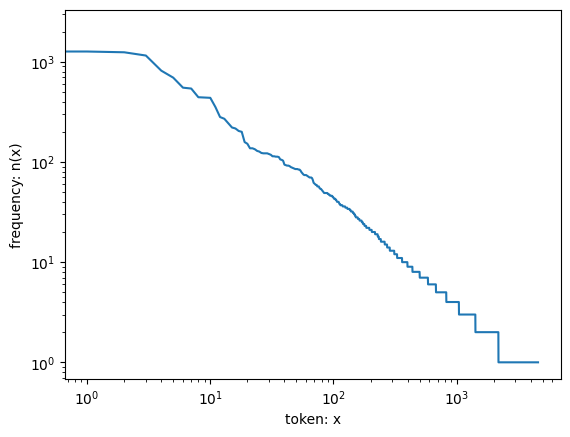

In [13]:
freqs = [freq for token, freq in vocab.token_freqs]
plt.plot(freqs)
plt.xlabel('token: x')
plt.ylabel('frequency: n(x)')
plt.xscale('log')
plt.yscale('log')
plt.show()

Certainly! Let's explain bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])] with a conceptual example.

This line is creating bigrams from your list of words. A bigram is a sequence of two consecutive words. It's a common technique in natural language processing to capture short phrases or common word pairs.

Let's imagine your words list looks like this:

Original words list: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']

Now, let's break down the list comprehension step-by-step:

words[:-1]: This takes all words from the beginning up to, but not including, the last word.

Result: ['the', 'time', 'machine', 'by', 'h', 'g']
words[1:]: This takes all words from the second word (index 1) to the end of the list.

Result: ['time', 'machine', 'by', 'h', 'g', 'wells']
zip(words[:-1], words[1:]): The zip() function takes corresponding elements from each of these two lists and combines them into pairs (tuples).

It takes the first element from words[:-1] ('the') and the first from words[1:] ('time').
Then the second element from each, and so on.
Result (sequence of pairs): [('the', 'time'), ('time', 'machine'), ('machine', 'by'), ('by', 'h'), ('h', 'g'), ('g', 'wells')]
for pair in ...: This is the loop that iterates through each pair created by the zip() function.

First iteration: pair is ('the', 'time')
Second iteration: pair is ('time', 'machine')
... and so on.
'--'.join(pair): For each pair (which is a tuple of two words), this joins the two words together into a single string, using '--' as the separator.

For ('the', 'time'): '--'.join(('the', 'time')) becomes 'the--time'
For ('time', 'machine'): '--'.join(('time', 'machine')) becomes 'time--machine'
For ('machine', 'by'): '--'.join(('machine', 'by')) becomes 'machine--by'
And so on.
[ ... ]: All these newly formed bigram strings are collected into a new list.

Final bigram_tokens list: ['the--time', 'time--machine', 'machine--by', 'by--h', 'h--g', 'g--wells']

In essence, this line efficiently creates a list of all consecutive word pairs (bigrams) from your original words list, separated by '--'. This new list of bigrams can then be used to build a vocabulary for bigram analysis.

In [14]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[('of--the', 309),
 ('in--the', 169),
 ('i--had', 130),
 ('i--was', 112),
 ('and--the', 109),
 ('the--time', 102),
 ('it--was', 99),
 ('to--the', 85),
 ('as--i', 78),
 ('of--a', 73)]

In [15]:
trigram_tokens = ['--'.join(triple) for triple in zip(
    words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 59),
 ('the--time--machine', 30),
 ('the--medical--man', 24),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('seemed--to--me', 14),
 ('i--did--not', 14),
 ('i--saw--the', 13),
 ('i--began--to', 13)]

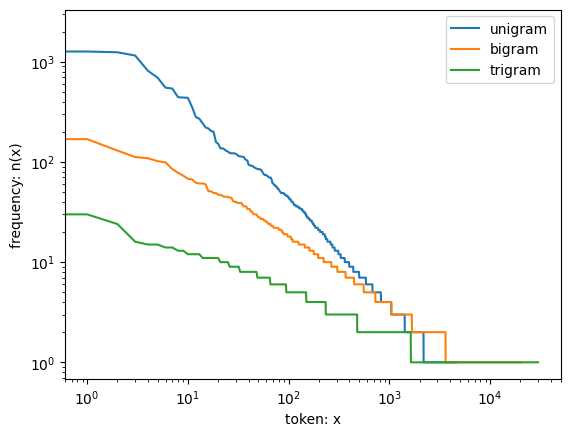

In [16]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]

plt.plot(freqs, label='unigram')
plt.plot(bigram_freqs, label='bigram')
plt.plot(trigram_freqs, label='trigram')

plt.xlabel('token: x')
plt.ylabel('frequency: n(x)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [17]:
data = TimeMachine(batch_size=2, num_steps=10)
for X, Y in data.get_dataloader(train=True):
    print('X:', X, '\nY:', Y)
    break

X: tensor([[ 4, 21, 10, 16, 15,  0,  2, 21,  0, 19],
        [ 4,  2, 13, 13,  0, 13,  6, 15,  8, 21]]) 
Y: tensor([[21, 10, 16, 15,  0,  2, 21,  0, 19, 10],
        [ 2, 13, 13,  0, 13,  6, 15,  8, 21,  9]])


In [18]:
X, W_xh = torch.randn(3, 1), torch.randn(1, 4)
H, W_hh = torch.randn(3, 4), torch.randn(4, 4)
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)

tensor([[-1.5968,  1.3484,  1.3728, -2.0385],
        [ 4.0570, -1.1745, -1.3656,  2.6335],
        [ 1.3107,  2.1889,  2.3708, -0.5603]])

Let's explain torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0)) with the same numerical example we used before. This is a common optimization to combine multiple matrix multiplications into one, which can be more efficient, especially on specialized hardware like GPUs.

Recall our example values:

Input X (current input): [[2]] (shape 1x1)
Input-to-Hidden Weights W_xh: [[0.5, 0.1]] (shape 1x2)
Previous Hidden State H: [[1, 3]] (shape 1x2)
Hidden-to-Hidden Weights W_hh: [[0.2, 0.3], [0.4, 0.6]] (shape 2x2)
Step 1: torch.cat((X, H), 1) (Concatenate X and H along dimension 1)

X is [[2]]
H is [[1, 3]]
Concatenating along dimension 1 means joining them column-wise (side-by-side). They must have the same number of rows, which they do (1 row each).
Result (let's call this Combined_Input):

[[2, 1, 3]]
This Combined_Input has a shape of 1x3. It effectively places the current input value next to the previous hidden state values.

Step 2: torch.cat((W_xh, W_hh), 0) (Concatenate W_xh and W_hh along dimension 0)

W_xh is [[0.5, 0.1]]
W_hh is [[0.2, 0.3], [0.4, 0.6]]
Concatenating along dimension 0 means stacking them row-wise (one on top of the other). They must have the same number of columns, which they do (2 columns each).
Result (let's call this Combined_Weights):

[[0.5, 0.1],  // From W_xh
 [0.2, 0.3],  // From W_hh (first row)
 [0.4, 0.6]]   // From W_hh (second row)
This Combined_Weights has a shape of 3x2. It stacks the input-to-hidden weights on top of the hidden-to-hidden weights.

Step 3: torch.matmul(Combined_Input, Combined_Weights) (Perform the final matrix multiplication)

Now we multiply the Combined_Input (1x3) by the Combined_Weights (3x2):

[[2, 1, 3]] multiplied by [[0.5, 0.1], [0.2, 0.3], [0.4, 0.6]]

Let's calculate the elements of the resulting 1x2 matrix:

First element: (2 * 0.5) + (1 * 0.2) + (3 * 0.4) = 1.0 + 0.2 + 1.2 = 2.4

Second element: (2 * 0.1) + (1 * 0.3) + (3 * 0.6) = 0.2 + 0.3 + 1.8 = 2.3

Final Result:

[[2.4, 2.3]]
As you can see, this result [[2.4, 2.3]] is exactly the same as the sum of the two separate matrix multiplications we performed previously ([[1.0, 0.2]] + [[1.4, 2.1]]). This technique groups related operations into a single larger matrix multiplication, which can be much faster for numerical libraries.

In [19]:
torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0))

tensor([[-1.5968,  1.3484,  1.3728, -2.0385],
        [ 4.0570, -1.1745, -1.3656,  2.6335],
        [ 1.3107,  2.1889,  2.3708, -0.5603]])

In [20]:
import math
import torch
from torch import nn
from torch.nn import functional as F

In [21]:
class RNNScratch(nn.Module):
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.sigma = sigma # Store sigma as an instance attribute
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

    def forward(self, inputs, state=None):
        if state is None:
            # Initial state with shape: (batch_size, num_hiddens)
            state = torch.zeros((inputs.shape[1], self.num_hiddens),
                              device=inputs.device)
        else:
            state, = state
        outputs = []
        for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
            state = torch.tanh(torch.matmul(X, self.W_xh) +
                             torch.matmul(state, self.W_hh) + self.b_h)
            outputs.append(state)
        return outputs, state

In [22]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

In [23]:
def check_len(a, n):
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape):
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

Let's assume we are calling model.predict('it has', 20, data.vocab).

prefix: This is the input string given to the predict method, which is 'it has' in our example.

prefix[0]: This Python string indexing operation gets the first character of the prefix. So, prefix[0] would evaluate to 'i'.

vocab: This is an instance of our Vocab class, created using the tokens from the "Time Machine" text (data.vocab). It maps characters (tokens) to numerical indices.

vocab[prefix[0]] (or vocab['i']): When you use square brackets like this with a Vocab instance, it calls the __getitem__ method of the Vocab class. Since 'i' is a single character (not a list or tuple), __getitem__ will look up its numerical index in the self.token_to_idx dictionary within the vocab object.

Based on our vocab from cell WUzAOuYOK5RWG, if 'i' was among the initial tokens, it would have an index. Let's look at data.vocab's token frequencies from cell bHq-dBZyJiUB and corpus values from ksqdMhJNDOPl.

In cell WUzAOuYOK5RWG, indices = vocab[tokens[:10]] showed that 'i' mapped to 10 when tokens were characters. The data.vocab built from the full character corpus in cell ksqdMhJNDOPl would also have a mapping for 'i'.

Therefore, vocab[prefix[0]] (or vocab['i']) would return the numerical index corresponding to the character 'i' in our vocabulary. This index is then used to initialize the outputs list, which will eventually form the generated sequence of characters.

In [24]:
class RNNLMScratch(nn.Module):
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.rnn = rnn # Store the RNN instance
        self.vocab_size = vocab_size
        self.loss = nn.CrossEntropyLoss() # Initialize the loss function
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        # self.plot('ppl', torch.exp(l), train=True) # Removed as self.plot is undefined
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        # self.plot('ppl', torch.exp(l), train=False) # Removed as self.plot is undefined

    def one_hot(self, X):
        # Output shape: (num_steps, batch_size, vocab_size)
        return F.one_hot(X.T, self.vocab_size).type(torch.float32)

    def output_layer(self, rnn_outputs):
        outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
        return torch.stack(outputs, 1)

    def forward(self, X, state=None):
        embs = self.one_hot(X)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)

    def predict(self, prefix, num_preds, vocab, device=None):
        state, outputs = None, [vocab[prefix[0]]]
        for i in range(len(prefix) + num_preds - 1):
            X = torch.tensor([[outputs[-1]]], device=device)
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            if i < len(prefix) - 1:  # Warm-up period
                outputs.append(vocab[prefix[i + 1]])
            else:  # Predict num_preds steps
                Y = self.output_layer(rnn_outputs)
                outputs.append(int(Y.argmax(axis=2).reshape(1)))
        return ''.join([vocab.idx_to_token[i] for i in outputs])

In [25]:
F.one_hot(torch.tensor([0, 2]), 5)

tensor([[1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]])

In [27]:
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab))
outputs = model(torch.ones((data.batch_size, data.num_steps), dtype=torch.int64))
check_shape(outputs, (data.batch_size, data.num_steps, len(data.vocab)))

In [28]:
data = TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.predict('it has', 20, data.vocab, device)

'it hasssssssssssssssssssss'

Concise Implementation of Recurrent Neural Networks

In [30]:
class RNN(nn.Module):
    """The RNN model implemented with high-level APIs."""
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.rnn = nn.RNN(num_inputs, num_hiddens)

    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)

In [31]:
class RNNLM(RNNLMScratch):
    """The RNN-based language model implemented with high-level APIs."""
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)

    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)

In [32]:
data = TimeMachine(batch_size=1024, num_steps=32)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=1)
model.predict('it has', 20, data.vocab)

'it hasdddddddddddddddddddd'

In [33]:
model.predict('it has', 20, data.vocab, device)

'it hasdddddddddddddddddddd'